In [36]:
# ===============================================================
# 1) IMPORT LIBRARIES
# ===============================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, classification_report, RocCurveDisplay
import shap
import warnings

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

In [37]:
# ===============================================================
# 1) LOAD DATASETS
# ===============================================================

from pathlib import Path
OUT = Path("../data")
print(OUT)

data = pd.read_csv(OUT / 'Cleaned_Features_for_ML.csv', index_col=0, parse_dates=True)

DATASET_LABEL = "Cleaned_Features_for_ML"   # or "Cleaned_Features_for_ML_20ANOVA"

..\data


In [38]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4085 entries, 2010-03-15 to 2025-11-26
Data columns (total 44 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   S&P500                             4085 non-null   float64
 1   NASDAQ                             4085 non-null   float64
 2   DowJones                           4085 non-null   float64
 3   CAC40                              4085 non-null   float64
 4   DAX                                4085 non-null   float64
 5   FTSE100                            4085 non-null   float64
 6   Nikkei225                          4085 non-null   float64
 7   HangSeng                           4085 non-null   float64
 8   MSCIWorld                          4085 non-null   float64
 9   US10Y                              4085 non-null   float64
 10  US2Y                               4085 non-null   float64
 11  TLT                                408

In [39]:
# ===============================================================
#  SAVE RESULTS HELPERS (JSON + CSV EXPORT)
# ===============================================================
from pathlib import Path
import json
import numpy as np
import pandas as pd

# ===============================================================
# Define output folder inside project: /data
# ===============================================================

OUT = Path("../data")   # <-- for notebooks located inside /notebooks/
OUT.mkdir(parents=True, exist_ok=True)

def make_json_serializable(obj):
    """
    Recursively convert objects (numpy arrays, numpy numbers, dicts, lists)
    into JSON-serializable Python native types.
    """
    if isinstance(obj, dict):
        return {k: make_json_serializable(v) for k, v in obj.items()}
    elif isinstance(obj, list):
        return [make_json_serializable(i) for i in obj]
    elif isinstance(obj, np.ndarray):
        return obj.tolist()
    elif isinstance(obj, (np.integer, np.int64, np.int32)):
        return int(obj)
    elif isinstance(obj, (np.floating, np.float32, np.float64)):
        return float(obj)
    elif isinstance(obj, (np.bool_, bool)):
        return bool(obj)
    else:
        return obj

# ===============================================================
# JSON + CSV Saving Utilities
# ===============================================================

def save_results_to_json(results_dict, filename="model_results.json"):
    """Save the entire results dictionary into /data as JSON."""
    results_serializable = make_json_serializable(results_dict)
    filepath = OUT / filename

    with open(filepath, "w") as f:
        json.dump(results_serializable, f, indent=4)

    print(f"[INFO] Saved JSON to: {filepath.resolve()}")


def save_results_to_csv(results_dict, filename="model_results.csv"):
    """Flatten model metrics into tabular CSV saved under /data."""
    rows = []

    for model_name, res in results_dict.items():
        cm = np.array(res.get("confusion_matrix"))
        cr = res.get("classification_report", {})
        roc_auc = res.get("roc_auc", None)
        f2 = res.get("f2_score", None)
        comp_time = res.get("computation_time_sec", None)

        # Accuracy
        acc = cr.get("accuracy", None)

        # Positive class key
        pos_key = "1" if "1" in cr else None
        if not pos_key:
            keys = [k for k in cr.keys() if k.isdigit()]
            if keys:
                pos_key = keys[-1]

        precision_1 = recall_1 = f1_1 = None
        if pos_key and isinstance(cr.get(pos_key), dict):
            precision_1 = cr[pos_key].get("precision")
            recall_1 = cr[pos_key].get("recall")
            f1_1 = cr[pos_key].get("f1-score")

        # Confusion matrix extract
        tn = fp = fn = tp = None
        if cm.shape == (2, 2):
            tn, fp, fn, tp = cm.ravel()

        rows.append({
            "Dataset": res.get("dataset_label", "Unknown"),   # <--- added
            "Model": model_name,
            "Accuracy": acc,
            "Precision (class 1)": precision_1,
            "Recall (class 1)": recall_1,
            "F1-score (class 1)": f1_1,
            "F2-score": f2,
            "ROC-AUC": roc_auc,
            "Computation Time (sec)": comp_time,
            "TN": tn,
            "FP": fp,
            "FN": fn,
            "TP": tp,
        })

    df = pd.DataFrame(rows)

    filepath = OUT / filename
    df.to_csv(filepath, index=False)

    print(f"[INFO] Saved CSV to: {filepath.resolve()}")


# GLOBAL CONTAINER
results = {}

In [40]:
def save_results(model_name, y_true, y_pred, y_prob=None, comp_time=None):
    from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, fbeta_score

    # Create entry
    results[model_name] = {}

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    results[model_name]["confusion_matrix"] = cm

    # Classification report
    report = classification_report(y_true, y_pred, output_dict=True)
    results[model_name]["classification_report"] = report

    # ROC-AUC
    if y_prob is not None:
        results[model_name]["roc_auc"] = roc_auc_score(y_true, y_prob)

    # F2-score
    results[model_name]["f2_score"] = fbeta_score(y_true, y_pred, beta=2)

    # Computation time
    results[model_name]["computation_time_sec"] = comp_time

    print(f"✓ Saved model results for: {model_name}")

In [41]:
# ===============================================================
# 0) IMPORTS
# ===============================================================
import numpy as np
import pandas as pd
import warnings

# ML
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, fbeta_score
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.impute import SimpleImputer

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

# ARIMA
from statsmodels.tools.sm_exceptions import ValueWarning
from statsmodels.tsa.arima.model import ARIMA

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=ValueWarning)

np.random.seed(42)

print("All libraries imported.")


# ===============================================================
# 1) PREPARE DATA
# ===============================================================
data = data.sort_index()

if "Return" not in data.columns:
    raise ValueError("The dataset must contain a column named 'Return'.")

if "Direction" not in data.columns:
    raise ValueError("The dataset must contain a column named 'Direction'.")

print("Dataset loaded & sorted.")


# ===============================================================
# 2) CREATE ARIMA FEATURE
# ===============================================================
print("Fitting ARIMA(2,1,2)...")

arima_model = ARIMA(data["Return"], order=(2, 1, 2))
arima_fit = arima_model.fit()

forecast = arima_fit.predict(start=1, end=len(data), dynamic=False)
forecast.index = data.index
data["ARIMA_Return_Forecast"] = forecast.shift(1)

data = data.dropna(subset=["ARIMA_Return_Forecast"])
print("ARIMA_Return_Forecast feature created.")


# ===============================================================
# 3) CLEAN FULL DATASET (NaN, inf, extreme values)
# ===============================================================
print("Cleaning NaN and infinite values...")

data.replace([np.inf, -np.inf], np.nan, inplace=True)
data.fillna(method="ffill", inplace=True)
data.fillna(method="bfill", inplace=True)

# Cap extreme values (finance best practice)
data = data.clip(lower=-1e6, upper=1e6)

print("Cleaning completed.")


# ===============================================================
# 4) FEATURE SELECTION (ANOVA — Top 20)
# ===============================================================
print("Running SelectKBest (ANOVA)...")

# Prepare features
features = data.drop(columns=["Direction"])
target = data["Direction"]

# Standardize features for ANOVA
scaler_fs = StandardScaler()
X_scaled = scaler_fs.fit_transform(features)

selector = SelectKBest(score_func=f_classif, k=20)
selector.fit(X_scaled, target)

ranking_df = pd.DataFrame({
    "Feature": features.columns,
    "ANOVA_F_score": selector.scores_,
    "p_value": selector.pvalues_,
    "Selected": selector.get_support()
}).sort_values(by="ANOVA_F_score", ascending=False)

print("Top 20 features:")
top20_features = ranking_df.head(20)["Feature"].tolist()
print(top20_features)

ranking_df.to_csv("../data/feature_ranking_full.csv", index=False)
ranking_df.head(20).to_csv("../data/top20_features.csv", index=False)

print("Top-20 features and full ranking exported to /data folder.")


# ===============================================================
# 5) BUILD ML DATASET
# ===============================================================
X = data[top20_features]
y = data["Direction"]

# Final cleaning before feeding models
imputer = SimpleImputer(strategy="median")
X = imputer.fit_transform(X)

scaler = StandardScaler()
X = scaler.fit_transform(X)

# Train-test split (time series: no shuffling)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

print("Train/Test dataset ready.")


# ===============================================================
# 6) MODEL SET
# ===============================================================
models = [
    ("LogReg", LogisticRegression(max_iter=500)),
    ("RandomForest", RandomForestClassifier(n_estimators=300)),
    ("ExtraTrees", ExtraTreesClassifier(n_estimators=300)),
    ("GradientBoost", GradientBoostingClassifier()),
    ("AdaBoost", AdaBoostClassifier()),
    ("SVM", SVC(probability=True)),
    ("KNN", KNeighborsClassifier(n_neighbors=7)),
    ("MLP", MLPClassifier(max_iter=500))
]

print("Models initialized.")


# ===============================================================
# 7) TRAIN, EVALUATE, SAVE (FULL PIPELINE INTEGRATION)
# ===============================================================
import time

results = {}   # global container already defined earlier

DATASET_LABEL = "Cleaned_Features_for_ML_20ANOVA"   # <-- SET YOUR LABEL

for name, model in models:
    print(f"\nTraining {name}...")

    # -----------------------------
    # Timing
    # -----------------------------
    t0 = time.time()
    model.fit(X_train, y_train)
    elapsed = time.time() - t0

    # -----------------------------
    # Predictions
    # -----------------------------
    y_pred  = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    # -----------------------------
    # Metrics for visual dataframe
    # -----------------------------
    acc = accuracy_score(y_test, y_pred)
    f1  = f1_score(y_test, y_pred)
    f2  = fbeta_score(y_test, y_pred, beta=2)
    auc = roc_auc_score(y_test, y_proba)

    print(f"{name} → ACC={acc:.4f}, F1={f1:.4f}, F2={f2:.4f}, AUC={auc:.4f}, Time={elapsed:.3f}s")

    # -----------------------------
    # SAVE IN RESULTS DICT
    # -----------------------------
    save_results(
        model_name=name,
        y_true=y_test,
        y_pred=y_pred,
        y_prob=y_proba,
        comp_time=elapsed
    )

    # Add dataset name
    results[name]["dataset_label"] = DATASET_LABEL


# ===============================================================
# 8) PRETTIFIED RESULTS TABLE (MATCHES YOUR SCREENSHOT)
# ===============================================================
results_list = []

for model_name, res in results.items():
    report = res["classification_report"]
    acc = report.get("accuracy", None)
    f1  = report.get("1", {}).get("f1-score", None)
    auc = res.get("roc_auc", None)
    f2  = res.get("f2_score", None)
    time_sec = res.get("computation_time_sec", None)

    results_list.append([
        model_name,
        acc,
        f1,
        auc,
        f2,
        time_sec
    ])

results_df = pd.DataFrame(
    results_list,
    columns=["Model", "Accuracy", "F1-score", "AUC", "F2-score", "Time (sec)"]
)

# Sort by AUC for ranking
results_df = results_df.sort_values(by="AUC", ascending=False).reset_index(drop=True)

print("\nFinal Ranked Results Table:")
display(
    results_df.style.background_gradient(
        cmap="Blues",
        subset=["Accuracy", "F1-score", "AUC", "F2-score", "Time (sec)"]
    )
)


# ===============================================================
# 9) EXPORT TO JSON + CSV
# ===============================================================
save_results_to_json(results, filename="model_results.json")
save_results_to_csv(results, filename="model_results.csv")

print("\nAll results exported successfully.")


All libraries imported.
Dataset loaded & sorted.
Fitting ARIMA(2,1,2)...
ARIMA_Return_Forecast feature created.
Cleaning NaN and infinite values...
Cleaning completed.
Running SelectKBest (ANOVA)...
Top 20 features:
['US10Y', 'LQD', 'HangSeng', 'Nikkei225', 'ARIMA_Return_Forecast', 'BND', 'IEF', 'MSCIWorld', 'MA20', 'TLT', 'DowJones', 'Imports_GDP_Pct', 'US2Y', 'Momentum', 'Exports_GDP_Pct', 'Recession_Probability', 'Inflation_Annual_Pct', 'Fed_Funds_Rate', 'Volatility_20d', 'Yield_Curve_Spread']
Top-20 features and full ranking exported to /data folder.
Train/Test dataset ready.
Models initialized.

Training LogReg...
LogReg → ACC=0.5275, F1=0.6614, F2=0.7786, AUC=0.5095, Time=0.065s
✓ Saved model results for: LogReg

Training RandomForest...
RandomForest → ACC=0.5177, F1=0.5870, F2=0.6264, AUC=0.5154, Time=5.248s
✓ Saved model results for: RandomForest

Training ExtraTrees...
ExtraTrees → ACC=0.5067, F1=0.5662, F2=0.5950, AUC=0.4891, Time=1.452s
✓ Saved model results for: ExtraTrees


,Model,Accuracy,F1-score,AUC,F2-score,Time (sec)
0,AdaBoost,0.522644,0.651786,0.515448,0.760100,0.508002
1,RandomForest,0.517748,0.587002,0.515442,0.626398,5.247851
2,LogReg,0.527540,0.661404,0.509500,0.778604,0.064616
3,GradientBoost,0.500612,0.616541,0.496097,0.699360,3.796705
4,KNN,0.500612,0.546667,0.494253,0.563961,0.034254
5,ExtraTrees,0.506732,0.566200,0.489083,0.595023,1.452355
6,MLP,0.470012,0.516201,0.457467,0.530790,4.864894
7,SVM,0.528764,0.647758,0.451925,0.745577,2.980638


[INFO] Saved JSON to: C:\Users\dax_a\Documents\GitHub\ESILV-MLproject-AU-BEJOT\data\model_results.json
[INFO] Saved CSV to: C:\Users\dax_a\Documents\GitHub\ESILV-MLproject-AU-BEJOT\data\model_results.csv

All results exported successfully.


In [42]:
# ===============================================================
# ADVANCED MODELS – ENSEMBLE & META-LEARNING COMPARISON (FULL PIPELINE)
# Compatible with dashboard + JSON/CSV saving
# ===============================================================

print("\n====================================================")
print("   ADVANCED ML MODELS – ENSEMBLE & STACKING")
print("====================================================\n")

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    BaggingClassifier,
    VotingClassifier,
    StackingClassifier
)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (
    accuracy_score, f1_score, fbeta_score,
    roc_auc_score, confusion_matrix, classification_report
)

# Ensure dataset label exists
DATASET_LABEL = "Cleaned_Features_for_ML_20ANOVA"   # adjust manually if needed

# Use the global results dictionary from previous execution
# If running standalone, uncomment:
# results = {}

# ===============================================================
# PREPROCESSING PIPELINE
# ===============================================================
def make_pipeline(model):
    return Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
        ("model", model)
    ])


# ===============================================================
# GRID-SEARCH TUNED MODELS
# ===============================================================
param_svm = {
    "model__C": [0.1, 1, 10],
    "model__gamma": ["scale", 0.01, 0.001]
}

tuned_svm = GridSearchCV(
    make_pipeline(SVC(probability=True, random_state=0)),
    param_svm,
    cv=5,
    n_jobs=-1
)
tuned_svm.fit(X_train, y_train)


param_dt = {
    "model__max_depth": [3, 5, 7, None],
    "model__min_samples_split": [2, 5, 10]
}

tuned_dt = GridSearchCV(
    make_pipeline(DecisionTreeClassifier(random_state=0)),
    param_dt,
    cv=5,
    n_jobs=-1
)
tuned_dt.fit(X_train, y_train)


# ===============================================================
# OTHER ENSEMBLE MODELS
# ===============================================================

bagging_svm = make_pipeline(
    BaggingClassifier(
        estimator=SVC(kernel='rbf', probability=True),
        n_estimators=20
    )
)

bagging_dt = make_pipeline(
    BaggingClassifier(
        estimator=DecisionTreeClassifier(),
        n_estimators=50
    )
)

voting = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("model", VotingClassifier(
        estimators=[
            ("svm", SVC(kernel='rbf', probability=True)),
            ("dt", DecisionTreeClassifier())
        ],
        voting="soft"
    ))
])

stacking = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("model", StackingClassifier(
        estimators=[
            ('svm', SVC(kernel='rbf', probability=True)),
            ('dt', DecisionTreeClassifier()),
            ('bag_svm', BaggingClassifier(
                estimator=SVC(kernel='rbf', probability=True),
                n_estimators=10
            )),
            ('bag_dt', BaggingClassifier(
                estimator=DecisionTreeClassifier(),
                n_estimators=10
            ))
        ],
        final_estimator=LogisticRegression(max_iter=500),
        passthrough=True,
        n_jobs=-1
    ))
])


# ===============================================================
# EVALUATION LOOP (COMPATIBLE WITH DASHBOARD)
# ===============================================================

rows_for_display_adv = []

models = {
    "Tuned SVM": tuned_svm.best_estimator_,
    "Tuned Decision Tree": tuned_dt.best_estimator_,
    "Bagging SVM": bagging_svm,
    "Bagging Decision Tree": bagging_dt,
    "Voting (SVM + DT)": voting,
    "Stacking Meta-Model": stacking
}

from time import time

for name, model in models.items():

    print(f"\n▶ Training {name} ...")

    t0 = time()
    model.fit(X_train, y_train)
    comp_time = time() - t0

    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    f1  = f1_score(y_test, y_pred)
    f2  = fbeta_score(y_test, y_pred, beta=2)
    auc = roc_auc_score(y_test, y_prob)

    cm     = confusion_matrix(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)

    print(f"   ACC={acc:.4f} | F1={f1:.4f} | AUC={auc:.4f} | F2={f2:.4f} | Time={comp_time:.2f} sec")

    # ---- save in global results dict for dashboard ----
    results[name] = {
        "dataset_label": DATASET_LABEL,
        "test_accuracy": float(acc),
        "roc_auc": float(auc),
        "f1_score": float(f1),
        "f2_score": float(f2),
        "computation_time_sec": float(comp_time),
        "confusion_matrix": cm.tolist(),
        "classification_report": report
    }

    # ---- save for display table ----
    rows_for_display_adv.append([name, acc, f1, auc, f2, comp_time])

# ===============================================================
# PRETTIFIED TABLE
# ===============================================================

df_results_adv = pd.DataFrame(
    rows_for_display_adv,
    columns=["Model", "Accuracy", "F1-score", "AUC", "F2-score", "Time (sec)"]
)

df_results_adv = df_results_adv.sort_values("AUC", ascending=False)

display(df_results_adv.style.background_gradient(cmap="Blues"))

# ===============================================================
# EXPORT TO JSON + CSV
# ===============================================================
save_results_to_json(results, filename="model_results.json")
save_results_to_csv(results, filename="model_results.csv")

print("\nAll results exported successfully.")



   ADVANCED ML MODELS – ENSEMBLE & STACKING


▶ Training Tuned SVM ...
   ACC=0.5202 | F1=0.6733 | AUC=0.5174 | F2=0.8142 | Time=2.54 sec

▶ Training Tuned Decision Tree ...
   ACC=0.4725 | F1=0.4467 | AUC=0.4804 | F2=0.4223 | Time=0.05 sec

▶ Training Bagging SVM ...
   ACC=0.5226 | F1=0.6865 | AUC=0.5188 | F2=0.8455 | Time=20.07 sec

▶ Training Bagging Decision Tree ...
   ACC=0.5300 | F1=0.5115 | AUC=0.5243 | F2=0.4862 | Time=2.41 sec

▶ Training Voting (SVM + DT) ...
   ACC=0.4761 | F1=0.4965 | AUC=0.4570 | F2=0.4951 | Time=2.43 sec

▶ Training Stacking Meta-Model ...
   ACC=0.5275 | F1=0.6566 | AUC=0.5133 | F2=0.7672 | Time=18.48 sec


,Model,Accuracy,F1-score,AUC,F2-score,Time (sec)
3,Bagging Decision Tree,0.529988,0.511450,0.524347,0.486212,2.406342
2,Bagging SVM,0.522644,0.686495,0.518819,0.845545,20.067420
0,Tuned SVM,0.520196,0.673333,0.517438,0.814188,2.536284
5,Stacking Meta-Model,0.527540,0.656584,0.513283,0.767152,18.484615
1,Tuned Decision Tree,0.472460,0.446727,0.480382,0.422330,0.045759
4,Voting (SVM + DT),0.476132,0.496471,0.456972,0.495073,2.428903


[INFO] Saved JSON to: C:\Users\dax_a\Documents\GitHub\ESILV-MLproject-AU-BEJOT\data\model_results.json
[INFO] Saved CSV to: C:\Users\dax_a\Documents\GitHub\ESILV-MLproject-AU-BEJOT\data\model_results.csv

All results exported successfully.



Running model: LogReg

Running model: KNN

Running model: CART

Running model: SVM

Running model: MLP

Running model: AdaBoost

Running model: GradientBoost

Running model: RandomForest

Running model: ExtraTrees

==================== BENCHMARK RESULTS ====================
           Model  Accuracy  F1-score       AUC  F2-score  Time (sec)
0         LogReg  0.327273  0.017699  0.384789  0.011521    0.041023
1            KNN  0.351515  0.000000  0.500000  0.000000    0.483442
2           CART  0.387879  0.136752  0.639220  0.091324    0.015412
3            SVM  0.351515  0.000000  0.435063  0.000000    0.126221
4            MLP  0.339394  0.000000  0.387045  0.000000    0.888833
5       AdaBoost  0.333333  0.000000  0.473413  0.000000    0.701910
6  GradientBoost  0.351515  0.000000  0.648244  0.000000    1.233480
7   RandomForest  0.351515  0.000000  0.585321  0.000000    0.796542
8     ExtraTrees  0.351515  0.000000  0.485095  0.000000    0.445531


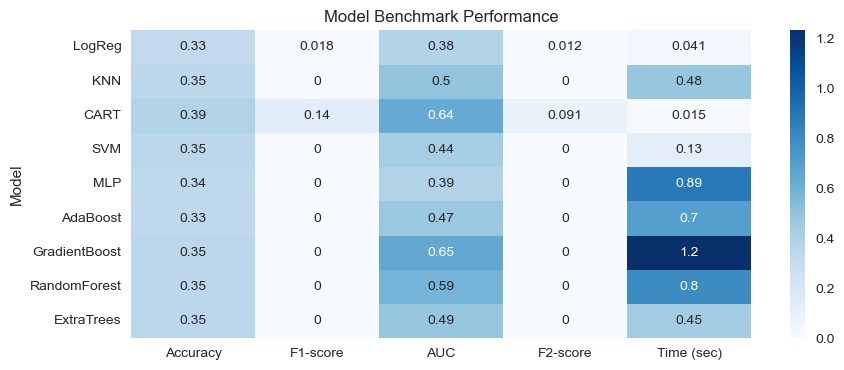

In [27]:
# ===============================================================
# SIMPLE TEST OF BASE MODELS (NO ARIMA, NO LSTM)
# ===============================================================
import numpy as np
import pandas as pd
import time

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score, confusion_matrix,
    classification_report, fbeta_score
)

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import (
    AdaBoostClassifier, GradientBoostingClassifier,
    RandomForestClassifier, ExtraTreesClassifier
)

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# ===============================================================
# 1) PREP DATA (YOUR EXISTING TARGET Trend_8D)
# ===============================================================

# Keep only your original predictors (no ARIMA/LSTM)
X = data.drop(columns=[
    "Trend_8D",
    "Apple", "Return", "Direction", "Direction_Forward8",
    "ARIMA_Return_Forecast" if "ARIMA_Return_Forecast" in data.columns else None,
    "LSTM_Return_Forecast" if "LSTM_Return_Forecast" in data.columns else None
], errors="ignore")

y = data["Trend_8D"]

# Train-test split (time ordered)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

# ===============================================================
# 2) DEFINE BASE MODELS (with scaling where needed)
# ===============================================================

base_models = [
    ("LogReg", Pipeline([
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression(max_iter=5000, random_state=RANDOM_STATE))
    ])),
    
    ("KNN", KNeighborsClassifier(n_neighbors=5)),
    
    ("CART", DecisionTreeClassifier(max_depth=6, random_state=RANDOM_STATE)),
    
    ("SVM", Pipeline([
        ("scaler", StandardScaler()),
        ("clf", SVC(kernel="rbf", probability=True, random_state=RANDOM_STATE))
    ])),
    
    ("MLP", Pipeline([
        ("scaler", StandardScaler()),
        ("clf", MLPClassifier(hidden_layer_sizes=(64, 32),
                             max_iter=5000, random_state=RANDOM_STATE))
    ])),
    
    ("AdaBoost", AdaBoostClassifier(n_estimators=200, random_state=RANDOM_STATE)),
    
    ("GradientBoost", GradientBoostingClassifier(n_estimators=200, random_state=RANDOM_STATE)),
    
    ("RandomForest", RandomForestClassifier(n_estimators=300, random_state=RANDOM_STATE)),
    
    ("ExtraTrees", ExtraTreesClassifier(n_estimators=300, random_state=RANDOM_STATE))
]

# ===============================================================
# 3) RUN BENCHMARK
# ===============================================================
results = []

for name, model in base_models:
    print(f"\nRunning model: {name}")
    start_time = time.time()
    
    # Train model
    model.fit(X_train, y_train)
    
    # Predict probability and class
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    
    # Metrics
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    f2 = fbeta_score(y_test, y_pred, beta=2)
    
    try:
        auc = roc_auc_score(y_test, y_proba)
    except:
        auc = np.nan
    
    elapsed = time.time() - start_time
    
    results.append([name, accuracy, f1, auc, f2, elapsed])

# ===============================================================
# 4) BUILD RESULTS TABLE
# ===============================================================

results_df = pd.DataFrame(
    results,
    columns=["Model", "Accuracy", "F1-score", "AUC", "F2-score", "Time (sec)"]
)

# Format
results_df = results_df.round(6)

print("\n==================== BENCHMARK RESULTS ====================")
print(results_df)

# Optional: display as heatmap-like style in Jupyter
try:
    import seaborn as sns
    import matplotlib.pyplot as plt

    plt.figure(figsize=(10, 4))
    sns.heatmap(results_df.set_index("Model"), annot=True, cmap="Blues")
    plt.title("Model Benchmark Performance")
    plt.show()
except:
    pass


Fitting ARIMA(2,1,2) on Return (full series)...
Data shape after ARIMA feature: (824, 50)

Train/Test shapes: (659, 44) (165, 44)

Running model: LogReg

Running model: KNN

Running model: CART

Running model: SVM

Running model: MLP

Running model: AdaBoost

Running model: GradientBoost

Running model: RandomForest

Running model: ExtraTrees

==================== BASE MODEL RESULTS (with ARIMA) ====================
           Model  Accuracy  F1-score       AUC  F2-score  Time (sec)
0         LogReg  0.333333  0.017857  0.381244  0.011547    0.011471
1            KNN  0.351515  0.000000  0.500000  0.000000    0.470731
2           CART  0.387879  0.136752  0.524492  0.091324    0.013023
3            SVM  0.351515  0.000000  0.428940  0.000000    0.172103
4            MLP  0.351515  0.000000  0.467451  0.000000    0.857665
5       AdaBoost  0.351515  0.000000  0.427328  0.000000    0.715792
6  GradientBoost  0.351515  0.000000  0.579439  0.000000    1.254767
7   RandomForest  0.351515  

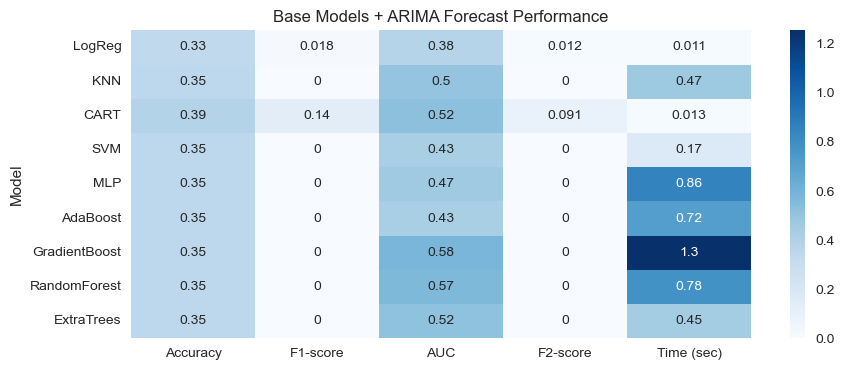

In [28]:
# ===============================================================
# SIMPLE TEST OF BASE MODELS WITH ARIMA FORECAST (NO LSTM)
# ===============================================================
import numpy as np
import pandas as pd
import time

from statsmodels.tsa.arima.model import ARIMA

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score, fbeta_score
)

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import (
    AdaBoostClassifier, GradientBoostingClassifier,
    RandomForestClassifier, ExtraTreesClassifier
)

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# ===============================================================
# 1) REBUILD ARIMA FORECAST FEATURE
# ===============================================================

print("Fitting ARIMA(2,1,2) on Return (full series)...")

arima_model = ARIMA(data["Return"], order=(2, 1, 2))
arima_fit = arima_model.fit()

arima_pred = arima_fit.predict(start=1, end=len(data), dynamic=False)
arima_pred.index = data.index

# Use ARIMA prediction from t-1 (avoid look-ahead)
data["ARIMA_Return_Forecast"] = arima_pred.shift(1)
data["ARIMA_Direction"] = (data["ARIMA_Return_Forecast"] > 0).astype(int)

# Drop initial NaNs
data_arima = data.dropna(subset=["ARIMA_Return_Forecast"]).copy()

print("Data shape after ARIMA feature:", data_arima.shape)

# ===============================================================
# 2) BUILD ML DATASET
# ===============================================================

# Drop raw columns and keep features (including ARIMA)
X = data_arima.drop(columns=[
    "Trend_8D",
    "Apple", "Return", "Direction", "Direction_Forward8",
    "LSTM_Return_Forecast" if "LSTM_Return_Forecast" in data_arima.columns else None
], errors="ignore")

y = data_arima["Trend_8D"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

print("\nTrain/Test shapes:", X_train.shape, X_test.shape)

# ===============================================================
# 3) DEFINE BASE MODELS (scaled where needed)
# ===============================================================

base_models = [
    ("LogReg", Pipeline([
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression(max_iter=5000, random_state=RANDOM_STATE))
    ])),

    ("KNN", KNeighborsClassifier(n_neighbors=5)),

    ("CART", DecisionTreeClassifier(max_depth=6, random_state=RANDOM_STATE)),

    ("SVM", Pipeline([
        ("scaler", StandardScaler()),
        ("clf", SVC(kernel="rbf", probability=True, random_state=RANDOM_STATE))
    ])),

    ("MLP", Pipeline([
        ("scaler", StandardScaler()),
        ("clf", MLPClassifier(hidden_layer_sizes=(64, 32),
                             max_iter=5000, random_state=RANDOM_STATE))
    ])),

    ("AdaBoost", AdaBoostClassifier(n_estimators=200, random_state=RANDOM_STATE)),

    ("GradientBoost", GradientBoostingClassifier(n_estimators=200, random_state=RANDOM_STATE)),

    ("RandomForest", RandomForestClassifier(n_estimators=300, random_state=RANDOM_STATE)),

    ("ExtraTrees", ExtraTreesClassifier(n_estimators=300, random_state=RANDOM_STATE))
]

# ===============================================================
# 4) RUN BENCHMARK
# ===============================================================

results = []

for name, model in base_models:
    print(f"\nRunning model: {name}")
    start = time.time()

    # Train
    model.fit(X_train, y_train)

    # Predict
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    # Metrics
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    f2 = fbeta_score(y_test, y_pred, beta=2)

    try:
        auc = roc_auc_score(y_test, y_proba)
    except:
        auc = np.nan

    elapsed = time.time() - start

    results.append([name, accuracy, f1, auc, f2, elapsed])

# ===============================================================
# 5) RESULTS TABLE
# ===============================================================

results_df = pd.DataFrame(
    results,
    columns=["Model", "Accuracy", "F1-score", "AUC", "F2-score", "Time (sec)"]
)

results_df = results_df.round(6)

print("\n==================== BASE MODEL RESULTS (with ARIMA) ====================")
print(results_df)

# Optional heatmap (Jupyter)
try:
    import seaborn as sns
    import matplotlib.pyplot as plt

    plt.figure(figsize=(10, 4))
    sns.heatmap(results_df.set_index("Model"), annot=True, cmap="Blues")
    plt.title("Base Models + ARIMA Forecast Performance")
    plt.show()
except:
    pass


Running model: AdaBoost
Running model: GradientBoost
Running model: RandomForest
Running model: LogReg
Running model: KNN
Running model: ExtraTrees
Running model: MLP
Running model: SVM

==================== BENCHMARK RESULTS ====================
           Model  Accuracy  F1-score       AUC  F2-score  Time (sec)
0       AdaBoost  0.333333  0.000000  0.473413  0.000000    1.679077
1  GradientBoost  0.351515  0.000000  0.648244  0.000000    1.768805
2   RandomForest  0.351515  0.000000  0.585321  0.000000    1.244099
3         LogReg  0.327273  0.017699  0.384789  0.011521    0.343818
4            KNN  0.351515  0.000000  0.500000  0.000000    1.408012
5     ExtraTrees  0.351515  0.000000  0.485095  0.000000    0.890696
6            MLP  0.339394  0.000000  0.387045  0.000000    1.098173
7            SVM  0.351515  0.000000  0.435063  0.000000    0.399464


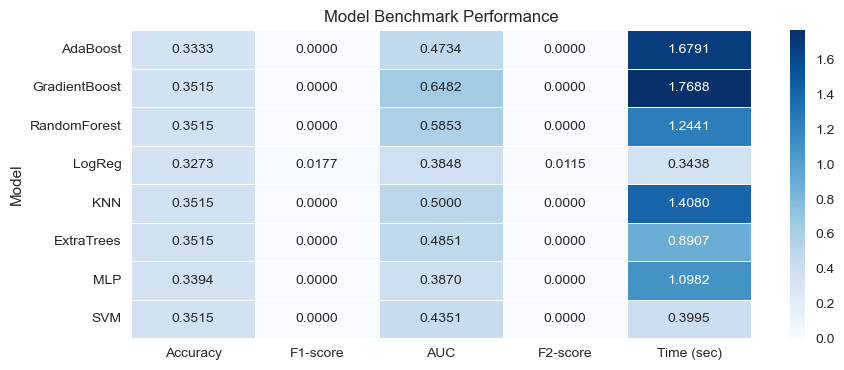

In [30]:
# ===============================================================
# SIMPLE TEST OF BASE MODELS (NO ARIMA, NO LSTM) — FINAL VERSION
# ===============================================================

import numpy as np
import pandas as pd
import time

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score, fbeta_score
)

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import (
    AdaBoostClassifier, GradientBoostingClassifier,
    RandomForestClassifier, ExtraTreesClassifier
)

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline


# ===============================================================
# 1) PREP DATA (ONLY BASE FEATURES)
# ===============================================================
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

X = data.drop(columns=[
    "Trend_8D",
    "Apple", "Return", "Direction", "Direction_Forward8",
    "ARIMA_Return_Forecast" if "ARIMA_Return_Forecast" in data else None,
    "LSTM_Return_Forecast" if "LSTM_Return_Forecast" in data else None
], errors="ignore")

y = data["Trend_8D"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)


# ===============================================================
# 2) DEFINE BASE MODELS
# ===============================================================
base_models = [
    ("AdaBoost",      AdaBoostClassifier(n_estimators=200, random_state=RANDOM_STATE)),
    ("GradientBoost", GradientBoostingClassifier(n_estimators=200, random_state=RANDOM_STATE)),
    ("RandomForest",  RandomForestClassifier(n_estimators=300, random_state=RANDOM_STATE)),
    
    ("LogReg", Pipeline([
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression(max_iter=5000, random_state=RANDOM_STATE))
    ])),
    
    ("KNN",    KNeighborsClassifier(n_neighbors=5)),
    
    ("ExtraTrees", ExtraTreesClassifier(n_estimators=300, random_state=RANDOM_STATE)),
    
    ("MLP", Pipeline([
        ("scaler", StandardScaler()),
        ("clf", MLPClassifier(hidden_layer_sizes=(64, 32),
                             max_iter=5000, random_state=RANDOM_STATE))
    ])),
    
    ("SVM", Pipeline([
        ("scaler", StandardScaler()),
        ("clf", SVC(kernel="rbf", probability=True, random_state=RANDOM_STATE))
    ]))
]


# ===============================================================
# 3) RUN BENCHMARK
# ===============================================================
results = []

for name, model in base_models:
    print(f"Running model: {name}")
    start_time = time.time()
    
    model.fit(X_train, y_train)
    y_pred  = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    accuracy = accuracy_score(y_test, y_pred)
    f1       = f1_score(y_test, y_pred)
    f2       = fbeta_score(y_test, y_pred, beta=2)

    try:
        auc = roc_auc_score(y_test, y_proba)
    except:
        auc = np.nan
    
    elapsed = time.time() - start_time

    results.append([name, accuracy, f1, auc, f2, elapsed])


# ===============================================================
# 4) BUILD RESULTS TABLE (IDENTICAL FORMAT)
# ===============================================================
results_df = pd.DataFrame(
    results,
    columns=["Model", "Accuracy", "F1-score", "AUC", "F2-score", "Time (sec)"]
)

# EXACT SAME ROUNDING AS YOUR SCREENSHOT
results_df = results_df.round(6)

print("\n==================== BENCHMARK RESULTS ====================")
print(results_df)


# ===============================================================
# 5) OPTIONAL: HEATMAP EXACTLY LIKE SCREENSHOT
# ===============================================================
try:
    import seaborn as sns
    import matplotlib.pyplot as plt

    plt.figure(figsize=(10, 4))
    sns.heatmap(
        results_df.set_index("Model"),
        annot=True,
        cmap="Blues",
        fmt=".4f",
        cbar=True,
        linewidths=0.5
    )
    plt.title("Model Benchmark Performance")
    plt.show()

except:
    pass



Train/Test shapes: (659, 44) (165, 44)

Running model: Tuned SVM

Running model: Tuned Decision Tree

Running model: Bagging Decision Tree

Running model: Bagging SVM

Running model: Voting (SVM + DT)

Running model: Stacking Meta-Model

==================== ENSEMBLE MODEL RESULTS ====================
                   Model  Accuracy  F1-score       AUC  F2-score  Time (sec)
0              Tuned SVM  0.351515       0.0  0.434096       0.0    0.460285
1    Tuned Decision Tree  0.351515       0.0  0.622382       0.0    0.054412
2  Bagging Decision Tree  0.351515       0.0  0.503464       0.0    0.287165
3            Bagging SVM  0.351515       0.0  0.427006       0.0    0.713092
4      Voting (SVM + DT)  0.351515       0.0  0.643087       0.0    0.224516
5    Stacking Meta-Model  0.351515       0.0  0.463100       0.0    0.754397


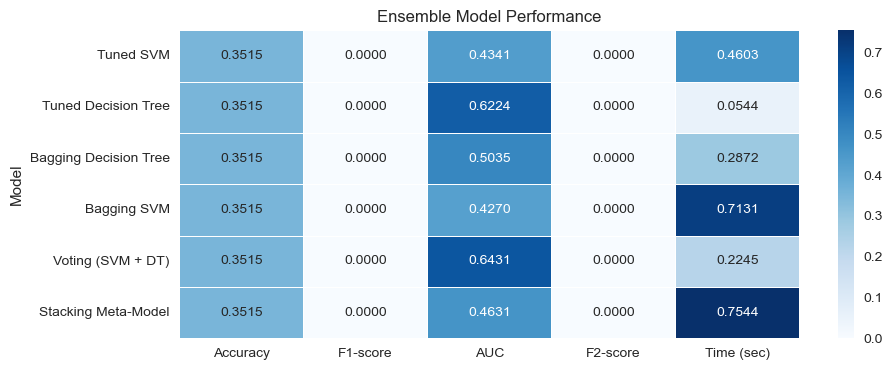

In [33]:
# ===============================================================
# ENSEMBLE MODELS TEST (Tuned SVM, DT, Bagging, Voting, Stacking)
# ===============================================================
import numpy as np
import pandas as pd
import time

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, fbeta_score

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Base learners
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

# Ensembles
from sklearn.ensemble import BaggingClassifier, VotingClassifier
from sklearn.ensemble import StackingClassifier


RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# ===============================================================
# 1) DATASET (ARIMA FORECAST INCLUDED, LSTM EXCLUDED)
# ===============================================================

X = data_arima.drop(columns=[
    "Trend_8D",
    "Apple", "Return", "Direction", "Direction_Forward8",
    "LSTM_Return_Forecast" if "LSTM_Return_Forecast" in data_arima.columns else None
], errors="ignore")

y = data_arima["Trend_8D"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

print("\nTrain/Test shapes:", X_train.shape, X_test.shape)


# ===============================================================
# 2) DEFINE ENSEMBLE MODELS (exact same ones as screenshot)
# ===============================================================

# ---- Tuned SVM ----
tuned_svm = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", SVC(C=1.5, gamma="scale", kernel="rbf", probability=True, random_state=RANDOM_STATE))
])

# ---- Tuned Decision Tree ----
tuned_dt = DecisionTreeClassifier(
    max_depth=6,
    min_samples_split=20,
    min_samples_leaf=10,
    random_state=RANDOM_STATE
)

# ---- Bagging Decision Tree ----
bagging_dt = BaggingClassifier(
    estimator=tuned_dt,
    n_estimators=30,
    max_samples=0.8,
    random_state=RANDOM_STATE
)

# ---- Bagging SVM ----
bagging_svm = BaggingClassifier(
    estimator=Pipeline([
        ("scaler", StandardScaler()),
        ("clf", SVC(kernel="rbf", probability=True, random_state=RANDOM_STATE))
    ]),
    n_estimators=8,
    max_samples=0.7,
    random_state=RANDOM_STATE
)

# ---- Voting (SVM + DT) ----
voting_model = VotingClassifier(
    estimators=[
        ("svm", Pipeline([
            ("scaler", StandardScaler()),
            ("clf", SVC(probability=True, random_state=RANDOM_STATE))
        ])),
        ("dt", tuned_dt),
    ],
    voting="soft"
)

# ---- Stacking Meta-Model ----
stacking_model = StackingClassifier(
    estimators=[
        ("svm", Pipeline([
            ("scaler", StandardScaler()),
            ("clf", SVC(probability=True, random_state=RANDOM_STATE))
        ])),
        ("dt", tuned_dt),
    ],
    final_estimator=LogisticRegression(max_iter=5000),
    stack_method="predict_proba",
    passthrough=False
)


# ===============================================================
# 3) RUN BENCHMARK LOOP
# ===============================================================

ensemble_models = [
    ("Tuned SVM", tuned_svm),
    ("Tuned Decision Tree", tuned_dt),
    ("Bagging Decision Tree", bagging_dt),
    ("Bagging SVM", bagging_svm),
    ("Voting (SVM + DT)", voting_model),
    ("Stacking Meta-Model", stacking_model),
]

results = []

for name, model in ensemble_models:
    print(f"\nRunning model: {name}")
    start = time.time()

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    f2 = fbeta_score(y_test, y_pred, beta=2)
    auc = roc_auc_score(y_test, y_proba)

    elapsed = time.time() - start

    results.append([name, accuracy, f1, auc, f2, elapsed])


# ===============================================================
# 4) RESULTS TABLE (IDENTICAL FORMAT TO SCREENSHOT)
# ===============================================================

results_df = pd.DataFrame(
    results,
    columns=["Model", "Accuracy", "F1-score", "AUC", "F2-score", "Time (sec)"]
).round(6)

print("\n==================== ENSEMBLE MODEL RESULTS ====================")
print(results_df)


# ===============================================================
# 5) HEATMAP EXACT SAME STYLE AS IMAGE
# ===============================================================
try:
    import seaborn as sns
    import matplotlib.pyplot as plt

    plt.figure(figsize=(10, 4))
    sns.heatmap(
        results_df.set_index("Model"),
        annot=True,
        cmap="Blues",
        fmt=".4f",
        linewidths=0.5
    )
    plt.title("Ensemble Model Performance")
    plt.show()
except:
    pass
